![Banner](./img/AI_Special_Program_Banner.jpg)  


# Sample solution for exercises LE10
---

In this exercise, you are to reconstruct an analysis by [David Robinson](http://varianceexplained.org/r/tidy-genomics/) in Python/Pandas. In this analysis, David Robinson used R to analyze a dataset on gene expression in yeast cultures. The main task is to convert the dataset into a tidy data format. This should allow the data to be easily filtered and visualized.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Reading in the data

In [2]:
df_gene = pd.read_csv('./data/Brauer2008_DataSet1.tds', delimiter='\t')

In [3]:
df_gene.head()

,GID,YORF,NAME,GWEIGHT,G0.05,G0.1,G0.15,G0.2,G0.25,G0.3,...,L0.15,L0.2,L0.25,L0.3,U0.05,U0.1,U0.15,U0.2,U0.25,U0.3
0,GENE1331X,A_06_P5820,SFB2 || ER to Golgi transport || molecul...,1,-0.24,-0.13,-0.21,-0.15,-0.05,-0.05,...,0.13,0.20,0.17,0.11,-0.06,-0.26,-0.05,-0.28,-0.19,0.09
1,GENE4924X,A_06_P5866,|| biological process unknown || mol...,1,0.28,0.13,-0.40,-0.48,-0.11,0.17,...,0.02,0.04,0.03,0.01,-1.02,-0.91,-0.59,-0.61,-0.17,0.18
2,GENE4690X,A_06_P1834,QRI7 || proteolysis and peptidolysis || ...,1,-0.02,-0.27,-0.27,-0.02,0.24,0.25,...,-0.07,-0.05,-0.13,-0.04,-0.91,-0.94,-0.42,-0.36,-0.49,-0.47
3,GENE1177X,A_06_P4928,CFT2 || mRNA polyadenylylation* || RNA b...,1,-0.33,-0.41,-0.24,-0.03,-0.03,0.00,...,-0.05,0.02,0.00,0.08,-0.53,-0.51,-0.26,0.05,-0.14,-0.01
4,GENE511X,A_06_P5620,SSO2 || vesicle fusion* || t-SNARE activ...,1,0.05,0.02,0.40,0.34,-0.13,-0.14,...,0.00,-0.11,0.04,0.01,-0.45,-0.09,-0.13,0.02,-0.09,-0.03


What is "untidy" here?

* **Column names are values and not variables** Our column names contain values for two variables: Nutrient (G,N,P, etc.) and Growth Rate (0.05-0.3). This gives us not one observation per row, but 36! This is a common problem in biological data; due to the high dimensionality, you often see one row per gene and one row per sample, instead of one row per gene per sample.
* **Multiple variables are stored in one column** The column `NAME` contains a lot of information, separated by `||`. More precisely, it contains information for:
    * Name of the gene e.g. SFB2. However, not all genes have a name
    * Biological process e.g. "proteolysis and peptidolysis"
    * Molecular function e.g. "metalloendopeptidase activity"
    * Systematic ID e.g. YNL049C. Each gene in this dataset has such an ID
    * Another ID e.g. 1082129. Unfortunately, it is not known what this ID represents.

In [4]:
df_gene.loc[2,'NAME']

'QRI7       || proteolysis and peptidolysis || metalloendopeptidase activity || YDL104C || 1085955'

We now want to solve both problems and convert our data into a Tidy Data format:

## Several variables are stored in one column

First we resolve the 'NAME' column:

In [5]:
col_names = ["name", "BP", "MF", "systematic_name", "number"]

The easiest way to extract the values is to create a new DataFrame:

In [6]:
df_name = pd.DataFrame(df_gene['NAME'].str.split('\|\|').values.tolist(), columns=col_names)
df_name.head()

,name,BP,MF,systematic_name,number
0,SFB2,ER to Golgi transport,molecular function unknown,YNL049C,1082129
1,,biological process unknown,molecular function unknown,YNL095C,1086222
2,QRI7,proteolysis and peptidolysis,metalloendopeptidase activity,YDL104C,1085955
3,CFT2,mRNA polyadenylylation*,RNA binding,YLR115W,1081958
4,SSO2,vesicle fusion*,t-SNARE activity,YMR183C,1081214


We then have to merge this with the first DataFrame:

In [7]:
df_gene_name = pd.concat([df_gene, df_name], axis=1)

The 'NAME' column is then no longer needed:

In [8]:
df_gene_name.drop('NAME', axis='columns', inplace=True)

Finally, we remove the whitespace in the values that occurs after the split:

In [9]:
for col in col_names:
    df_gene_name[col] = df_gene_name[col].str.strip()

## Column names are values and not variables

We then want to extract the values from the column names. As a reminder: The columns `G0.05` to `U0.3` contain information on the variables Nutrient and Growth Rate.

In [10]:
df_gene_name.columns

Index(['GID', 'YORF', 'GWEIGHT', 'G0.05', 'G0.1', 'G0.15', 'G0.2', 'G0.25',
       'G0.3', 'N0.05', 'N0.1', 'N0.15', 'N0.2', 'N0.25', 'N0.3', 'P0.05',
       'P0.1', 'P0.15', 'P0.2', 'P0.25', 'P0.3', 'S0.05', 'S0.1', 'S0.15',
       'S0.2', 'S0.25', 'S0.3', 'L0.05', 'L0.1', 'L0.15', 'L0.2', 'L0.25',
       'L0.3', 'U0.05', 'U0.1', 'U0.15', 'U0.2', 'U0.25', 'U0.3', 'name', 'BP',
       'MF', 'systematic_name', 'number'],
      dtype='object')

"Melting" the DataFrame with `pd.melt()`:

In [11]:
df_gene_name_melt = pd.melt(df_gene_name, id_vars=['GID', 'YORF', 'GWEIGHT', 'name', 'BP', 'MF', 'systematic_name', 'number'], var_name='sample', value_name='expression')
df_gene_name_melt.head()

,GID,YORF,GWEIGHT,name,BP,MF,systematic_name,number,sample,expression
0,GENE1331X,A_06_P5820,1,SFB2,ER to Golgi transport,molecular function unknown,YNL049C,1082129,G0.05,-0.24
1,GENE4924X,A_06_P5866,1,,biological process unknown,molecular function unknown,YNL095C,1086222,G0.05,0.28
2,GENE4690X,A_06_P1834,1,QRI7,proteolysis and peptidolysis,metalloendopeptidase activity,YDL104C,1085955,G0.05,-0.02
3,GENE1177X,A_06_P4928,1,CFT2,mRNA polyadenylylation*,RNA binding,YLR115W,1081958,G0.05,-0.33
4,GENE511X,A_06_P5620,1,SSO2,vesicle fusion*,t-SNARE activity,YMR183C,1081214,G0.05,0.05


This makes our DataFrame considerably longer:

In [12]:
df_gene_name.shape

(5537, 44)

In [13]:
df_gene_name_melt.shape

(199332, 10)

But now we have several variables in one column again: `nutrient` and `rate` in the `sample` column. We have to split these again. As this is a string with a fixed structure (`nutrient` is always the first character), we can simply slice the string:

In [14]:
df_gene_name_melt['nutrient'] = df_gene_name_melt['sample'].str[0]
df_gene_name_melt['rate'] = df_gene_name_melt['sample'].str[1:].astype('float64')

In [15]:
df_gene_name_melt.drop('sample', axis='columns', inplace=True)

In [16]:
df_gene_name_melt.head()

,GID,YORF,GWEIGHT,name,BP,MF,systematic_name,number,expression,nutrient,rate
0,GENE1331X,A_06_P5820,1,SFB2,ER to Golgi transport,molecular function unknown,YNL049C,1082129,-0.24,G,0.05
1,GENE4924X,A_06_P5866,1,,biological process unknown,molecular function unknown,YNL095C,1086222,0.28,G,0.05
2,GENE4690X,A_06_P1834,1,QRI7,proteolysis and peptidolysis,metalloendopeptidase activity,YDL104C,1085955,-0.02,G,0.05
3,GENE1177X,A_06_P4928,1,CFT2,mRNA polyadenylylation*,RNA binding,YLR115W,1081958,-0.33,G,0.05
4,GENE511X,A_06_P5620,1,SSO2,vesicle fusion*,t-SNARE activity,YMR183C,1081214,0.05,G,0.05


Our data is now available in Tidy Data format!

## Bonus: Visualization

In [17]:
mask = df_gene_name_melt['name'] == 'LEU1'

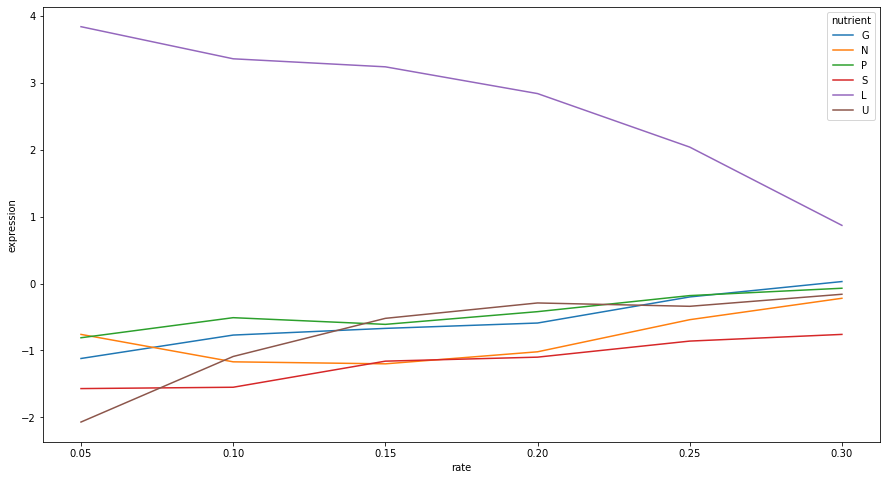

In [18]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_gene_name_melt[mask], x='rate', y='expression', hue='nutrient');

In [19]:
mask = df_gene_name_melt['BP'] == 'leucine biosynthesis'

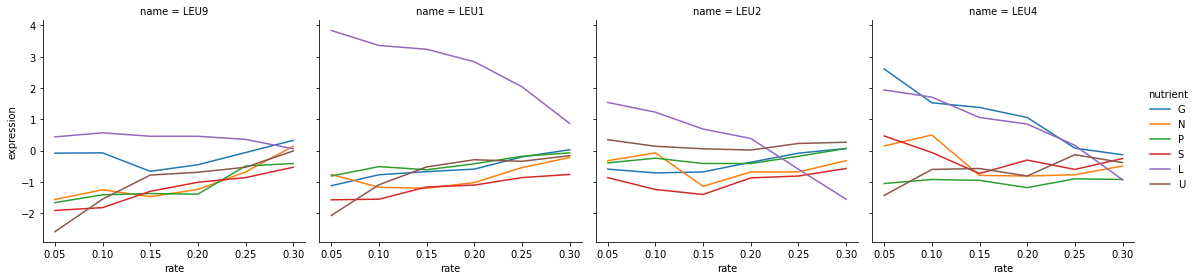

In [21]:
g = sns.FacetGrid(df_gene_name_melt[mask], col="name", hue='nutrient', height = 4)
g.map(sns.lineplot, "rate", "expression")
g.add_legend();